In [1]:

# To have reproducible results and compare them
nr_seed = 2021
import numpy as np 
np.random.seed(nr_seed)
import tensorflow as tf
tf.set_random_seed(nr_seed)

In [2]:
# import libraries
import json
import math
from tqdm import tqdm, tqdm_notebook
import gc
import warnings
import os

import cv2 # for computer vision
from PIL import Image

import pandas as pd
import scipy
import matplotlib.pyplot as plt

from keras import backend as K
from keras import layers
from keras.applications.densenet import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score

warnings.filterwarnings("ignore")

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Image size
im_size = 320
# Batch size
BATCH_SIZE = 32

# Loading & Merging

In [4]:
new_train = pd.read_csv('../input/aptos2019-blindness-detection/train.csv')
old_train = pd.read_csv('../input/diabetic-retinopathy-resized/trainLabels.csv')
print(new_train.shape)
print(old_train.shape)

(3662, 2)
(35126, 2)


In [5]:
old_train = old_train[['image','level']]
old_train.columns = new_train.columns
old_train.diagnosis.value_counts()

# path columns
new_train['id_code'] = '../input/aptos2019-blindness-detection/train_images/' + new_train['id_code'].astype(str) + '.png'
old_train['id_code'] = '../input/diabetic-retinopathy-resized/resized_train/resized_train/' + old_train['id_code'].astype(str) + '.jpeg'

train_df = old_train.copy()
val_df = new_train.copy()
train_df.head()

,id_code,diagnosis
0,../input/diabetic-retinopathy-resized/resized_...,0
1,../input/diabetic-retinopathy-resized/resized_...,0
2,../input/diabetic-retinopathy-resized/resized_...,0
3,../input/diabetic-retinopathy-resized/resized_...,0
4,../input/diabetic-retinopathy-resized/resized_...,1


## Train - Valid split

In [6]:
# Let's shuffle the datasets
train_df = train_df.sample(frac=1).reset_index(drop=True)
val_df = val_df.sample(frac=1).reset_index(drop=True)
print(train_df.shape)
print(val_df.shape)

(35126, 2)
(3662, 2)


### Process Images

In [7]:
def crop_image1(img,tol=7):
    # img is image data
    # tol  is tolerance
        
    mask = img>tol
    return img[np.ix_(mask.any(1),mask.any(0))]

def crop_image_from_gray(img,tol=7):
    if img.ndim ==2:
        mask = img>tol
        return img[np.ix_(mask.any(1),mask.any(0))]
    elif img.ndim==3:
        gray_img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        mask = gray_img>tol
        
        check_shape = img[:,:,0][np.ix_(mask.any(1),mask.any(0))].shape[0]
        if (check_shape == 0): # image is too dark so that we crop out everything,
            return img # return original image
        else:
            img1=img[:,:,0][np.ix_(mask.any(1),mask.any(0))]
            img2=img[:,:,1][np.ix_(mask.any(1),mask.any(0))]
            img3=img[:,:,2][np.ix_(mask.any(1),mask.any(0))]
            img = np.stack([img1,img2,img3],axis=-1)
        return img

def preprocess_image(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/30) ,-4 ,128)
    
    return img

def preprocess_image_old(image_path, desired_size=224):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #img = crop_image_from_gray(img)
    img = cv2.resize(img, (desired_size,desired_size))
    img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), desired_size/40) ,-4 ,128)
    
    return img

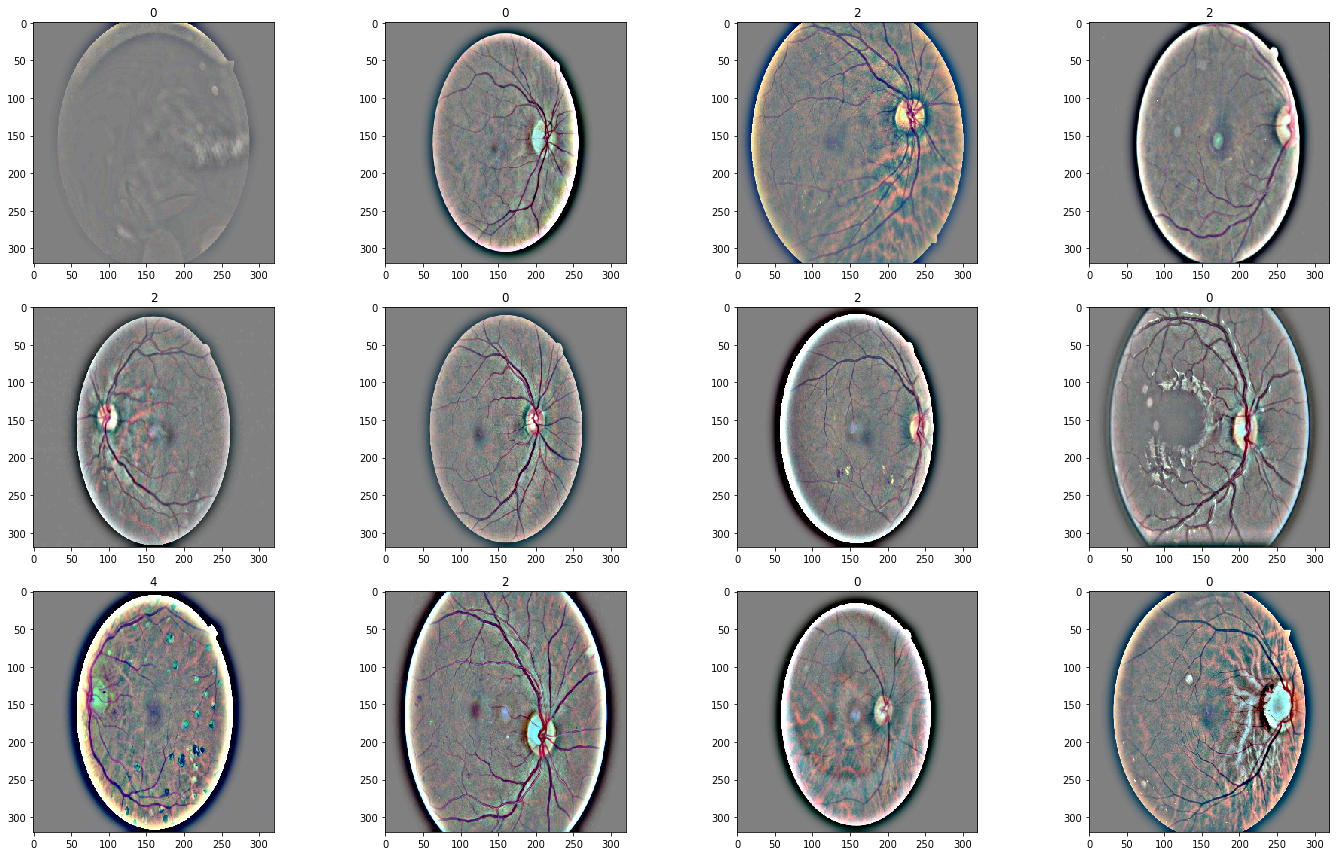

In [8]:
def display_samples(df, columns=4, rows=3):
    fig=plt.figure(figsize=(5*columns, 4*rows))

    for i in range(columns*rows):
        image_path = df.loc[i,'id_code']
        image_id = df.loc[i,'diagnosis']
        img = cv2.imread(f'{image_path}')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        #img = crop_image_from_gray(img)
        img = cv2.resize(img, (im_size,im_size))
        img = cv2.addWeighted(img,4,cv2.GaussianBlur(img, (0,0), im_size/40) ,-4 ,128)
        
        fig.add_subplot(rows, columns, i+1)
        plt.title(image_id)
        plt.imshow(img)
    
    plt.tight_layout()

display_samples(train_df)

# Processing Images

__UPDATE:__ Here we are reading just the validation set. In order to use 320x320 images, we are going to load one bucket at a time only when needed. This will let our code run without memory-related errors.

In [9]:
# validation set
N = val_df.shape[0]
x_val = np.empty((N, im_size, im_size, 3), dtype=np.uint8)

for i, image_id in enumerate(tqdm_notebook(val_df['id_code'])):
    x_val[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [10]:
y_train = pd.get_dummies(train_df['diagnosis']).values
y_val = pd.get_dummies(val_df['diagnosis']).values

print(y_train.shape)
print(x_val.shape)
print(y_val.shape)

(35126, 5)
(3662, 320, 320, 3)
(3662, 5)


# Creating multilabels

Instead of predicting a single label, we will change our target to be a multilabel problem; i.e., if the target is a certain class, then it encompasses all the classes before it. E.g. encoding a class 4 retinopathy would usually be `[0, 0, 0, 1]`, but in our case we will predict `[1, 1, 1, 1]`. 

In [11]:
y_train_multi = np.empty(y_train.shape, dtype=y_train.dtype)
y_train_multi[:, 4] = y_train[:, 4]

for i in range(3, -1, -1):
    y_train_multi[:, i] = np.logical_or(y_train[:, i], y_train_multi[:, i+1])

y_val_multi = np.empty(y_val.shape, dtype=y_val.dtype)
y_val_multi[:, 4] = y_val[:, 4]

for i in range(3, -1, -1):
    y_val_multi[:, i] = np.logical_or(y_val[:, i], y_val_multi[:, i+1])

print("Y_train multi: {}".format(y_train_multi.shape))
print("Y_val multi: {}".format(y_val_multi.shape))

Y_train multi: (35126, 5)
Y_val multi: (3662, 5)


In [12]:
y_train = y_train_multi
y_val = y_val_multi

In [13]:
# delete the uneeded df
del new_train
del old_train
del val_df
gc.collect()

27200

# Creating keras callback for QWK



In [14]:
class Metrics(Callback):

    def on_epoch_end(self, epoch, logs={}):
        X_val, y_val = self.validation_data[:2]
        y_val = y_val.sum(axis=1) - 1
        
        y_pred = self.model.predict(X_val) > 0.5
        y_pred = y_pred.astype(int).sum(axis=1) - 1

        _val_kappa = cohen_kappa_score(
            y_val,
            y_pred, 
            weights='quadratic'
        )

        self.val_kappas.append(_val_kappa)

        print(f"val_kappa: {_val_kappa:.4f}")
        
        if _val_kappa == max(self.val_kappas):
            print("Validation Kappa has improved. Saving model.")
            self.model.save('model.h5')

        return

# Data Generator

In [15]:
def create_datagen():
    return ImageDataGenerator(
        featurewise_std_normalization = True,
        horizontal_flip = True,
        vertical_flip = True,
        rotation_range = 360
    )

# Model: DenseNet-121

In [16]:
densenet = DenseNet121(
    weights='../input/densenet-keras/DenseNet-BC-121-32-no-top.h5',
    include_top=False,
    input_shape=(im_size,im_size,3)
)

In [17]:
def build_model():
    model = Sequential()
    model.add(densenet)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(5, activation='sigmoid'))
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=0.0001,decay=1e-6),
        metrics=['accuracy']
    )
    
    return model

In [18]:
model = build_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 5125      
Total params: 7,042,629
Trainable params: 6,958,981
Non-trainable params: 83,648
_________________________________________________________________
None


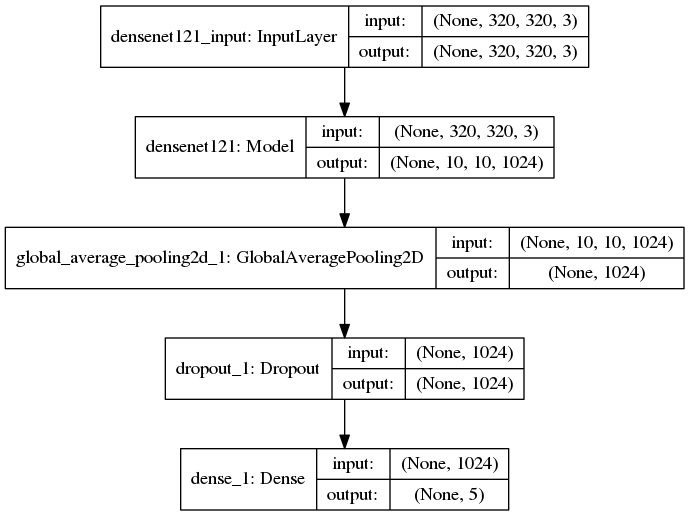

In [19]:
%matplotlib inline
from tensorflow.keras.utils import plot_model
plot_model(model, show_layer_names=True, show_shapes =True, to_file='modelLENET5.png')

In [20]:
#pip install h5py

# Training & Evaluation

In [21]:
#train_df = train_df.reset_index(drop=True)
bucket_num =8
div = round(train_df.shape[0]/bucket_num)

In [22]:
df_init = {
    'val_loss': [0.0],
    'val_acc': [0.0],
    'loss': [0.0], 
    'acc': [0.0],
    'bucket': [0.0]
}
results = pd.DataFrame(df_init)

In [23]:
# I found that changing the nr. of epochs for each bucket helped in terms of performances
epochs = [5,5,10,20,10,15,15,20]
kappa_metrics = Metrics()
kappa_metrics.val_kappas = []

In [24]:
for i in range(0,bucket_num):
    if i != (bucket_num-1):
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:(1+i)*div].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:(1+i)*div,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)

        data_generator = create_datagen().flow(x_train, y_train[i*div:(1+i)*div,:], batch_size=BATCH_SIZE)
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i
    else:
        print("Bucket Nr: {}".format(i))
        
        N = train_df.iloc[i*div:].shape[0]
        x_train = np.empty((N, im_size, im_size, 3), dtype=np.uint8)
        for j, image_id in enumerate(tqdm_notebook(train_df.iloc[i*div:,0])):
            x_train[j, :, :, :] = preprocess_image_old(f'{image_id}', desired_size = im_size)
        data_generator = create_datagen().flow(x_train, y_train[i*div:,:], batch_size=BATCH_SIZE)
        
        history = model.fit_generator(
                        data_generator,
                        steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
                        epochs=epochs[i],
                        validation_data=(x_val, y_val),
                        callbacks=[kappa_metrics]
                        )
        
        dic = history.history
        df_model = pd.DataFrame(dic)
        df_model['bucket'] = i

    results = results.append(df_model)
    
    del data_generator
    del x_train
    gc.collect()
    
    print('-'*40)

Bucket Nr: 0



Epoch 1/5
138/137 [==============================] - 179s 1s/step - loss: 0.3897 - acc: 0.8234 - val_loss: 0.2376 - val_acc: 0.9133
val_kappa: 0.7727
Validation Kappa has improved. Saving model.
Epoch 2/5
138/137 [==============================] - 138s 997ms/step - loss: 0.2388 - acc: 0.9044 - val_loss: 0.2925 - val_acc: 0.8856
val_kappa: 0.7960
Validation Kappa has improved. Saving model.
Epoch 3/5
138/137 [==============================] - 136s 985ms/step - loss: 0.2160 - acc: 0.9147 - val_loss: 0.2276 - val_acc: 0.9068
val_kappa: 0.7803
Epoch 4/5
138/137 [==============================] - 136s 988ms/step - loss: 0.2031 - acc: 0.9206 - val_loss: 0.2677 - val_acc: 0.8892
val_kappa: 0.6083
Epoch 5/5
138/137 [==============================] - 136s 988ms/step - loss: 0.1926 - acc: 0.9223 - val_loss: 0.2038 - val_acc: 0.9214
val_kappa: 0.8329
Validation Kappa has improved. Saving model.
----------------------------------------
Bucket Nr: 1



Epoch 1/5
138/137 [==============================] - 143s 1s/step - loss: 0.1904 - acc: 0.9258 - val_loss: 0.2074 - val_acc: 0.9187
val_kappa: 0.7532
Epoch 2/5
138/137 [==============================] - 136s 985ms/step - loss: 0.1799 - acc: 0.9301 - val_loss: 0.2035 - val_acc: 0.9273
val_kappa: 0.8605
Validation Kappa has improved. Saving model.
Epoch 3/5
138/137 [==============================] - 136s 988ms/step - loss: 0.1720 - acc: 0.9341 - val_loss: 0.2061 - val_acc: 0.9193
val_kappa: 0.7437
Epoch 4/5
138/137 [==============================] - 137s 990ms/step - loss: 0.1656 - acc: 0.9356 - val_loss: 0.1880 - val_acc: 0.9304
val_kappa: 0.8086
Epoch 5/5
138/137 [==============================] - 136s 988ms/step - loss: 0.1539 - acc: 0.9392 - val_loss: 0.2021 - val_acc: 0.9273
val_kappa: 0.7976
----------------------------------------
Bucket Nr: 2



Epoch 1/10
138/137 [==============================] - 143s 1s/step - loss: 0.1791 - acc: 0.9326 - val_loss: 0.2258 - val_acc: 0.9151
val_kappa: 0.8548
Epoch 2/10
138/137 [==============================] - 136s 985ms/step - loss: 0.1685 - acc: 0.9348 - val_loss: 0.2647 - val_acc: 0.8928
val_kappa: 0.8122
Epoch 3/10
138/137 [==============================] - 136s 986ms/step - loss: 0.1630 - acc: 0.9359 - val_loss: 0.1852 - val_acc: 0.9265
val_kappa: 0.8385
Epoch 4/10
138/137 [==============================] - 138s 1s/step - loss: 0.1566 - acc: 0.9391 - val_loss: 0.1777 - val_acc: 0.9295
val_kappa: 0.8287
Epoch 5/10
138/137 [==============================] - 137s 994ms/step - loss: 0.1475 - acc: 0.9425 - val_loss: 0.1831 - val_acc: 0.9303
val_kappa: 0.8166
Epoch 6/10
138/137 [==============================] - 137s 996ms/step - loss: 0.1468 - acc: 0.9443 - val_loss: 0.1786 - val_acc: 0.9330
val_kappa: 0.8508
Epoch 7/10
138/137 [==============================] - 138s 1s/step - loss: 0.1431


Epoch 1/20
138/137 [==============================] - 143s 1s/step - loss: 0.1663 - acc: 0.9352 - val_loss: 0.2778 - val_acc: 0.8977
val_kappa: 0.8153
Epoch 2/20
138/137 [==============================] - 137s 991ms/step - loss: 0.1542 - acc: 0.9403 - val_loss: 0.1651 - val_acc: 0.9370
val_kappa: 0.8664
Validation Kappa has improved. Saving model.
Epoch 3/20
138/137 [==============================] - 136s 988ms/step - loss: 0.1494 - acc: 0.9427 - val_loss: 0.1672 - val_acc: 0.9317
val_kappa: 0.8420
Epoch 4/20
138/137 [==============================] - 137s 993ms/step - loss: 0.1430 - acc: 0.9457 - val_loss: 0.1897 - val_acc: 0.9317
val_kappa: 0.7947
Epoch 5/20
138/137 [==============================] - 147s 1s/step - loss: 0.1375 - acc: 0.9471 - val_loss: 0.1722 - val_acc: 0.9333
val_kappa: 0.8214
Epoch 6/20
138/137 [==============================] - 155s 1s/step - loss: 0.1337 - acc: 0.9465 - val_loss: 0.2371 - val_acc: 0.9139
val_kappa: 0.7223
Epoch 7/20
138/137 [===================


Epoch 1/10
138/137 [==============================] - 142s 1s/step - loss: 0.1779 - acc: 0.9312 - val_loss: 0.1767 - val_acc: 0.9326
val_kappa: 0.8529
Epoch 2/10
138/137 [==============================] - 134s 971ms/step - loss: 0.1537 - acc: 0.9413 - val_loss: 0.1671 - val_acc: 0.9395
val_kappa: 0.8467
Epoch 3/10
138/137 [==============================] - 133s 967ms/step - loss: 0.1474 - acc: 0.9429 - val_loss: 0.2073 - val_acc: 0.9248
val_kappa: 0.7748
Epoch 4/10
138/137 [==============================] - 134s 968ms/step - loss: 0.1395 - acc: 0.9456 - val_loss: 0.1842 - val_acc: 0.9361
val_kappa: 0.8163
Epoch 5/10
138/137 [==============================] - 142s 1s/step - loss: 0.1377 - acc: 0.9462 - val_loss: 0.1955 - val_acc: 0.9384
val_kappa: 0.8357
Epoch 6/10
138/137 [==============================] - 143s 1s/step - loss: 0.1327 - acc: 0.9458 - val_loss: 0.1766 - val_acc: 0.9357
val_kappa: 0.8463
Epoch 7/10
138/137 [==============================] - 151s 1s/step - loss: 0.1288 - 


Epoch 1/15
138/137 [==============================] - 144s 1s/step - loss: 0.1722 - acc: 0.9359 - val_loss: 0.2054 - val_acc: 0.9279
val_kappa: 0.8575
Epoch 2/15
138/137 [==============================] - 136s 986ms/step - loss: 0.1520 - acc: 0.9409 - val_loss: 0.2095 - val_acc: 0.9319
val_kappa: 0.8562
Epoch 3/15
138/137 [==============================] - 136s 983ms/step - loss: 0.1434 - acc: 0.9470 - val_loss: 0.2472 - val_acc: 0.9263
val_kappa: 0.7595
Epoch 4/15
138/137 [==============================] - 136s 983ms/step - loss: 0.1385 - acc: 0.9470 - val_loss: 0.1850 - val_acc: 0.9380
val_kappa: 0.8650
Epoch 5/15
138/137 [==============================] - 136s 983ms/step - loss: 0.1329 - acc: 0.9485 - val_loss: 0.2236 - val_acc: 0.9299
val_kappa: 0.8084
Epoch 6/15
138/137 [==============================] - 136s 983ms/step - loss: 0.1310 - acc: 0.9496 - val_loss: 0.1999 - val_acc: 0.9310
val_kappa: 0.8531
Epoch 7/15
138/137 [==============================] - 136s 989ms/step - loss: 


Epoch 1/15
138/137 [==============================] - 143s 1s/step - loss: 0.1719 - acc: 0.9365 - val_loss: 0.2292 - val_acc: 0.9304
val_kappa: 0.8590
Epoch 2/15
138/137 [==============================] - 136s 984ms/step - loss: 0.1493 - acc: 0.9459 - val_loss: 0.2198 - val_acc: 0.9349
val_kappa: 0.8359
Epoch 3/15
138/137 [==============================] - 136s 986ms/step - loss: 0.1411 - acc: 0.9457 - val_loss: 0.2045 - val_acc: 0.9300
val_kappa: 0.8512
Epoch 4/15
138/137 [==============================] - 135s 979ms/step - loss: 0.1378 - acc: 0.9478 - val_loss: 0.3216 - val_acc: 0.9191
val_kappa: 0.7449
Epoch 5/15
138/137 [==============================] - 135s 981ms/step - loss: 0.1326 - acc: 0.9507 - val_loss: 0.2364 - val_acc: 0.9320
val_kappa: 0.8007
Epoch 6/15
138/137 [==============================] - 136s 983ms/step - loss: 0.1263 - acc: 0.9526 - val_loss: 0.5113 - val_acc: 0.8883
val_kappa: 0.5928
Epoch 7/15
138/137 [==============================] - 135s 979ms/step - loss: 


Epoch 1/20
138/137 [==============================] - 154s 1s/step - loss: 0.1746 - acc: 0.9370 - val_loss: 0.2597 - val_acc: 0.9315
val_kappa: 0.8205
Epoch 2/20
138/137 [==============================] - 142s 1s/step - loss: 0.1459 - acc: 0.9436 - val_loss: 0.2633 - val_acc: 0.9318
val_kappa: 0.7949
Epoch 3/20
138/137 [==============================] - 146s 1s/step - loss: 0.1430 - acc: 0.9459 - val_loss: 0.2352 - val_acc: 0.9309
val_kappa: 0.8056
Epoch 4/20
138/137 [==============================] - 143s 1s/step - loss: 0.1352 - acc: 0.9482 - val_loss: 0.2078 - val_acc: 0.9186
val_kappa: 0.8516
Epoch 5/20
138/137 [==============================] - 145s 1s/step - loss: 0.1280 - acc: 0.9522 - val_loss: 0.2341 - val_acc: 0.9318
val_kappa: 0.8131
Epoch 6/20
138/137 [==============================] - 146s 1s/step - loss: 0.1195 - acc: 0.9540 - val_loss: 0.3988 - val_acc: 0.9236
val_kappa: 0.7276
Epoch 7/20
138/137 [==============================] - 141s 1s/step - loss: 0.1143 - acc: 0.95

In [25]:
results = results.iloc[1:]
results['kappa'] = kappa_metrics.val_kappas
results = results.reset_index()
results = results.rename(index=str, columns={"index": "epoch"})
results

,epoch,val_loss,val_acc,loss,acc,bucket,kappa
0,0,0.237566,0.913326,0.390572,0.822865,0.0,0.772677
1,1,0.292472,0.885582,0.238852,0.904304,0.0,0.795998
2,2,0.227641,0.906827,0.215831,0.914826,0.0,0.780282
3,3,0.267655,0.889186,0.202955,0.920428,0.0,0.608322
4,4,0.203774,0.921354,0.191230,0.922842,0.0,0.832911
5,0,0.207442,0.918678,0.190740,0.925848,1.0,0.753169
6,1,0.203537,0.927253,0.180260,0.929902,1.0,0.860530
7,2,0.206142,0.919334,0.171333,0.934366,1.0,0.743693
8,3,0.187956,0.930421,0.166205,0.935231,1.0,0.808605
9,4,0.202141,0.927307,0.154152,0.939057,1.0,0.797623


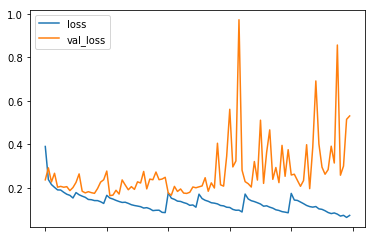

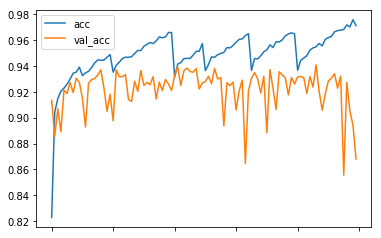

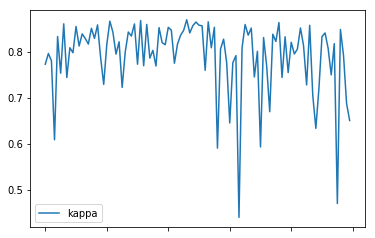

In [26]:
results[['loss', 'val_loss']].plot()
results[['acc', 'val_acc']].plot()
results[['kappa']].plot()
results.to_csv('model_results.csv',index=False)

# Find best threshold

In [27]:
model.load_weights('model.h5')
y_val_pred = model.predict(x_val)

def compute_score_inv(threshold):
    y1 = y_val_pred > threshold
    y1 = y1.astype(int).sum(axis=1) - 1
    y2 = y_val.sum(axis=1) - 1
    score = cohen_kappa_score(y1, y2, weights='quadratic')
    
    return 1 - score

simplex = scipy.optimize.minimize(
    compute_score_inv, 0.5, method='nelder-mead'
)

best_threshold = simplex['x'][0]

y1 = y_val_pred > best_threshold
y1 = y1.astype(int).sum(axis=1) - 1
y2 = y_val.sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Threshold: {}'.format(best_threshold))
print('Validation QWK score with best_threshold: {}'.format(score))

y1 = y_val_pred > .5
y1 = y1.astype(int).sum(axis=1) - 1
score = cohen_kappa_score(y1, y2, weights='quadratic')
print('Validation QWK score with .5 threshold: {}'.format(score))

Threshold: 0.4343749999999999
Validation QWK score with best_threshold: 0.8717796902932253
Validation QWK score with .5 threshold: 0.8694290850480426


## From here we need to run in Local

In [28]:
new_test = pd.read_csv('../input/aptos2019-blindness-detection/test.csv')

In [29]:
new_test['id_code'] = '../input/aptos2019-blindness-detection/test_images/' + new_test['id_code'].astype(str) + '.png'

In [30]:
test_df = new_test.copy()

In [31]:
# Test set
N = test_df.shape[0]
x_test = np.empty((N, im_size, im_size, 3), dtype=np.uint8)


In [32]:
for i, image_id in enumerate(tqdm_notebook(test_df['id_code'])):
    x_test[i, :, :, :] = preprocess_image(
        f'{image_id}',
        desired_size = im_size
    )

In [33]:
y_test = model.predict(x_test) > 0.5
y_test = y_test.astype(int).sum(axis=1) - 1

test_df['diagnosis'] = y_test
test_df.to_csv('submission.csv',index=False)